In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

In the OLS community, it is often believed that bivariate correlations are able to tell the existence of confounders. For instance, if Y $\sim$ X, X $\sim$ Z, and Y $\sim$ Z, then controlling for Z would undermine the linear relationship between Y and X. Is it really so?  Using simulations, this notebook tries to debunk this myth and demonstrates the effect of control in OLS regressions.

# Simulations

First, let's draw a sample from a multivariate normal distribution $\begin{bmatrix}
X \\
Y \\
Z \\
\end{bmatrix} \sim \mathcal{N}(\mathbf{\mu}, \mathbf{\Sigma})$ with

$\mathbf{\mu} = \begin{bmatrix}
0 \\
0 \\
0 \\
\end{bmatrix}$ and $\mathbf{\Sigma} = \begin{bmatrix}
1 & i & j \\
i & 1 & k \\
j & k & 1 \\
\end{bmatrix} = \begin{bmatrix}
1 & 0.9 & 0.9 \\
0.9 & 1 & 0.9 \\
0.9 & 0.9 & 1 \\
\end{bmatrix}
$

In [3]:
mean = np.array([0, 0, 0])
cov = np.array([[1, 0.9, 0.9], [0.9, 1, 0.9], [0.9, 0.9, 1]])
sample = np.random.multivariate_normal(mean, cov, 10000)

Note that the covariance matrix has to be [positive semidefinite](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Non-degenerate_case).
We can verify whether a matrix is positive semidefinite by checking whether [all of its eigenvalues are non-negative](https://en.wikipedia.org/wiki/Positive-definite_matrix#Characterizations).

In [4]:
eigenvalues = np.linalg.eig(cov)[0]
print(eigenvalues)

[0.1 2.8 0.1]


Let's get our sample x, y, and z.

In [5]:
x = sample[:,0]
y = sample[:,1]
z = sample[:,2]

Plot y against z.

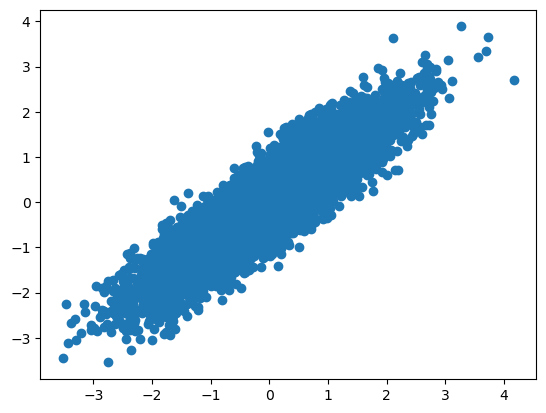

In [6]:
plt.scatter(y,z)
plt.show()

Regress y on x. The slope we get should be on average equal to $i = 0.9$. (See (29) in the Appendix section.)

In [7]:
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x) # make the predictions by the model
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                 4.093e+04
Date:                Mon, 15 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:41:33   Log-Likelihood:                -5942.0
No. Observations:               10000   AIC:                         1.189e+04
Df Residuals:                    9998   BIC:                         1.190e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.004     -0.047      0.963      -0.009       0.008
x1             0.8895      0.004    202.318      0.000       0.881       0.898
==============================================================================
Omnibus:                        1.070   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.586   Jarque-Bera (JB):                1.089
Skew:                           0.006   Prob(JB):                        0.580
Kurtosis:                       2.950   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This time, we regress y on x and z.

In [8]:
X = sample[:,[0,2]]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                 2.809e+04
Date:                Mon, 15 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:41:34   Log-Likelihood:                -4632.3
No. Observations:               10000   AIC:                             9271.
Df Residuals:                    9997   BIC:                             9292.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.004      0.520      0.603      -0.006       0.010
x1             0.4552      0.009     51.577      0.000       0.438       0.472
x2             0.4845      0.009     54.712      0.000       0.467       0.502
==============================================================================
Omnibus:                        0.025   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.988   Jarque-Bera (JB):                0.031
Skew:                           0.004   Prob(JB):                        0.985
Kurtosis:                       2.995   Cond. No.                         4.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The coefficients for x and z should be on average equal to $\frac{i-jk}{1-j^2}$ and $\frac{-ij + k}{1-j^2}$. (See (21) in the Appendix.) In our case, $\frac{i-jk}{1-j^2} = \frac{-ij + k}{1-j^2} = 0.473$. 

In [9]:
(0.9 - 0.9*0.9)/(1-0.9**2)

0.47368421052631576

So, in this particular case, including Z in the regression indeed makes the coefficient on X smaller. 

Let's see if this finding can be generalized by looping over all posible values of $i$, $j$, and $k$ from -0.9 to 0.9 with 0.1 increments.

In [10]:
values = [i * 0.1 for i in range(-9,10)]

In [11]:
OUTPUT = []
for i in values:
    for j in values:
        for k in values:
            mean = np.array([0, 0, 0])
            cov = np.array([[1, i, j], [i, 1, k], [j, k, 1]])
            eigenvalues = np.linalg.eig(cov)[0]
            if (eigenvalues[0] >= 0) and (eigenvalues[1] >=0) and (eigenvalues[2] >= 0):
                ps = True
                sample = np.random.multivariate_normal(mean, cov, 10000)
                x = sample[:,0]
                y = sample[:,1]
                z = sample[:,2]

                x = sm.add_constant(x)
                model = sm.OLS(y, x).fit()
                b1 = model.params[1]

                X = sample[:,[0,2]]
                X = sm.add_constant(X)
                model = sm.OLS(y, X).fit()
                b2 = model.params[1]
                beta = (i - j*k)/(1 - j**2)
                gamma = (-i*j + k)/(1 - j**2)

                if b1 > b2:
                    est = "overestimated"
                if b1 < b2:
                    est = "underestimated"
            else:
                ps = False
                b1 = None
                b2 = None
                est = None
                beta = None
                gamma = None

            row = [i, j, k, b1, b2, est, beta, ps, gamma]
            OUTPUT.append(row)         

And save the results to a dataframe.

In [12]:
results = pd.DataFrame(OUTPUT, columns = ["i","j","k","b_xy", "b_xyz", "estimate", "beta", "positive semidefinite", "gamma"])

Show only the rows with a positive semidefinite covariance matrix. "b_xy" is the estimated regression slope for x without controlling for z. "b_xyz" is the estimated regression slope for x after controlling for z. $\beta = \frac{i-jk}{1-j^2}$  and $\gamma = \frac{-ij + k}{1-j^2}$ are the theoretical slopes for X and Z. You can see from this table that "b_xy" is a very close estimate of $i$, and "b_xyz" is a very close estimate of $\beta$. 

Without controling for z, bias = $\gamma j$. When $\gamma j$ is postive, "b_xy" overestimates $\beta$. When $\gamma j$ is negative, "b_xy" underestimates $\beta$.

In [13]:
results[(results['positive semidefinite'] == True)]

,i,j,k,b_xy,b_xyz,estimate,beta,positive semidefinite,gamma
16,-0.9,-0.9,0.7,-0.902897,-1.410553,overestimated,-1.421053,True,-0.578947
17,-0.9,-0.9,0.8,-0.895188,-0.926884,overestimated,-0.947368,True,-0.052632
18,-0.9,-0.9,0.9,-0.903159,-0.478150,underestimated,-0.473684,True,0.473684
33,-0.9,-0.8,0.5,-0.899779,-1.389657,overestimated,-1.388889,True,-0.611111
34,-0.9,-0.8,0.6,-0.900013,-1.170034,overestimated,-1.166667,True,-0.333333
...,...,...,...,...,...,...,...,...,...
6838,0.9,0.8,0.8,0.909854,0.725262,overestimated,0.722222,True,0.222222
6839,0.9,0.8,0.9,0.904283,0.506119,overestimated,0.500000,True,0.500000
6856,0.9,0.9,0.7,0.900043,1.420639,underestimated,1.421053,True,-0.578947
6857,0.9,0.9,0.8,0.896327,0.952184,underestimated,0.947368,True,-0.052632


## Some interesting cases:

When X and Y, Y and Z are correlateed at 0.9, varying the correlation betweeen X and Z from 0.9 to 0.7 would vastly change the result of control.  

In [14]:
results[(results['positive semidefinite'] == True)].tail(3)

,i,j,k,b_xy,b_xyz,estimate,beta,positive semidefinite,gamma
6856,0.9,0.9,0.7,0.900043,1.420639,underestimated,1.421053,True,-0.578947
6857,0.9,0.9,0.8,0.896327,0.952184,underestimated,0.947368,True,-0.052632
6858,0.9,0.9,0.9,0.899231,0.462386,overestimated,0.473684,True,0.473684


In some cases, controling for Z wouldn't matter at all even though Z is correlated with both X and Y. 

In [15]:
results[(results['i'] == -0.8) & (results['j'] == -0.5) & (results['k'] == 0.4)]

,i,j,k,b_xy,b_xyz,estimate,beta,positive semidefinite,gamma
450,-0.8,-0.5,0.4,-0.803613,-0.803792,overestimated,-0.8,True,0.0


Z $\nsim$ X is no guarentee for Z not being a confounder for the relationship between X and Y. This is probably the most counter-intuitive part of the results. 

In [16]:
results[(results['k'] == 0)]

,i,j,k,b_xy,b_xyz,estimate,beta,positive semidefinite,gamma
9,-0.9,-0.9,0.0,NaN,NaN,None,NaN,False,NaN
28,-0.9,-0.8,0.0,NaN,NaN,None,NaN,False,NaN
47,-0.9,-0.7,0.0,NaN,NaN,None,NaN,False,NaN
66,-0.9,-0.6,0.0,NaN,NaN,None,NaN,False,NaN
85,-0.9,-0.5,0.0,NaN,NaN,None,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...
6773,0.9,0.5,0.0,NaN,NaN,None,NaN,False,NaN
6792,0.9,0.6,0.0,NaN,NaN,None,NaN,False,NaN
6811,0.9,0.7,0.0,NaN,NaN,None,NaN,False,NaN
6830,0.9,0.8,0.0,NaN,NaN,None,NaN,False,NaN


# Lessons

Bivariate associations can tell neither whether a third variable is a confounder nor the direction of bias it causes. What determines these issues are conditional associations rather than unconditional associations. See the appendix for a mathematical proof. 

# Appendix

<img src="Confounder_Page_1.png">

<img src="Confounder_Page_2.png">